# Plot decision boundary
> Can we plot decision boundaries?

In [2]:
%load_ext autoreload
%autoreload 2

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from geomstats.visualization import plot as gplot
from geomstats.geometry.hyperbolic import Hyperbolic

from sklearn.model_selection import train_test_split

from src.hyperdt.toy_data import generate_gaussian_mixture_hyperboloid
from src.hyperdt.tree import HyperbolicDecisionTreeClassifier


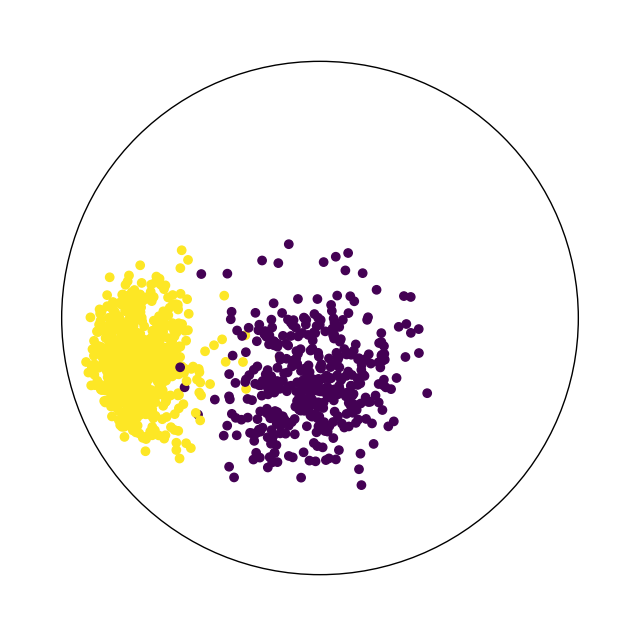

In [10]:
# Some data

X, y = generate_gaussian_mixture_hyperboloid(
    num_points=3000, num_classes=2, noise_std=0.1, seed=40
)  # Good seeds: (2 classes, 12); (4 classes, 12)

# plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax = gplot(
    X,
    c=y,
    space="H2_poincare_disk",
)
plt.show()


In [13]:
# Split into train and test sets; train HDT

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

hdt = HyperbolicDecisionTreeClassifier(timelike_dim=0, max_depth=1)
hdt.fit(X_train, y_train)

hdt_score = hdt.score(X_test, y_test)
print(hdt_score)


0.9912280701754386


In [54]:
# Let's see if we can figure out how to plot this

# Question: what is the equation for our decision hyperplane?
boundary_theta = hdt.tree.theta
boundary_dim = hdt.tree.feature

# So our normal vector is this:
normal_vector = np.zeros(X_train.shape[1])
normal_vector[0] = np.sin(boundary_theta)
normal_vector[boundary_dim] = np.cos(boundary_theta)

# Our hyperplane is defined by the equation:
# sin(theta) * x_0 + cos(theta) * x_d = 0
# x_0 = -cos(theta) * x_d / sin(theta)
# x_0 = -cot(theta) * x_d
# Letting x1 ... xd-1 = 0, we get:
# x_d^2 - x_0^2 = -1
# x_d^2 - (-cot(theta) * x_d)^2 = -1
# x_d = sqrt(1 / cot^2(x) - 1)
# cot2_theta = (1 / np.tan(boundary_theta)) ** 2
# x_d = np.sqrt(1 / (cot2_theta - 1))
# x_0_pos = -(1 / np.tan(boundary_theta)) * x_d
# x_0_neg = -(1 / np.tan(boundary_theta)) * -x_d

# Make some points
start_point = np.zeros(X_train.shape[1])
end_point = np.zeros(X_train.shape[1])
start_point[0] = x_0_pos
start_point[boundary_dim] = x_d
end_point[0] = x_0_neg
end_point[boundary_dim] = -x_d
# start_point[0] = 2.40364
# end_point[0] = -2.40364
# start_point[boundary_dim] = end_point[boundary_dim] = 2.18574

# Let's get our geodesic
hyperboloid = Hyperbolic(dim=2, default_coords_type="extrinsic")
geodesic_func = hyperboloid.metric.geodesic(
    initial_point=start_point,
    end_point=end_point,
)
geodesic_points = geodesic_func(np.linspace(0, 1, 100))
geodesic_points = geodesic_points[hyperboloid.belongs(geodesic_points)]


In [157]:
# ChatGPT: intersection code
from scipy.optimize import newton
from src.hyperdt.conversions import convert


def find_intersection(D, theta, t, t_dim=1, n_dim=3):
    # Define the hyperplane equation
    def hyperplane(x0, xD):
        return x0 * np.sin(theta) + xD * np.cos(theta)

    # Define the hyperboloid equation: assume all other coordinates are 0
    def hyperboloid_simplified(x0, x1, xD):
        return x1 ** 2 + xD ** 2 - x0 ** 2 + 1

    # Solve for x_0 using the hyperplane equation
    def solve_x0(xD):
        return -xD / np.tan(theta)

    # Substitute x_0 into the hyperboloid equation and solve for x_D
    def equation_to_solve(xD):
        return hyperboloid_simplified(x0=solve_x0(xD), x1=t, xD=xD)

    # Input validation:
    if D == t_dim:
        raise ValueError("dim and t_dim must be different")

    xD_solution = newton(equation_to_solve, 0)
    x0_solution = solve_x0(xD_solution)

    # return x_0_solution, x_D_solution, t
    out_vec = np.zeros(n_dim)
    out_vec[0] = -x0_solution
    out_vec[t_dim] = t
    out_vec[D] = -xD_solution

    return out_vec


# Start point, end point, geodesic:
# start_point = find_intersection(boundary_dim, boundary_theta, -10, t_dim=2)
# end_point = find_intersection(boundary_dim, boundary_theta, 10, t_dim=2)
# geodesic_func = hyperboloid.metric.geodesic(start_point, end_point)
# geodesic_points = geodesic_func(np.linspace(0, 1, 100))
geodesic_points = np.stack(
    [
        find_intersection(boundary_dim, boundary_theta, t, t_dim=2, n_dim=3)
        for t in np.linspace(10, -10, 100)
    ]
)

# Poincare conversion, since geomstats is being weird about it:
geodesic_poincare = convert(
    geodesic_points, "hyperboloid", "poincare", timelike_dim=0
)


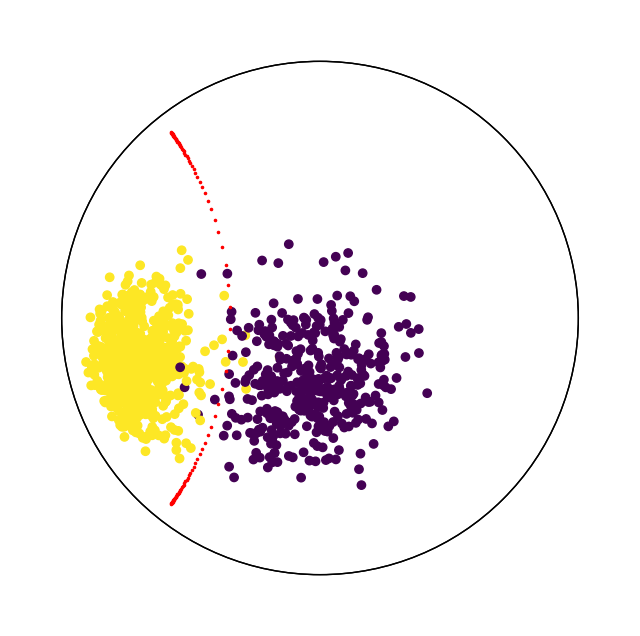

In [158]:
# Let's plot our data and our decision boundary
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax = gplot(
    X,
    c=y,
    space="H2_poincare_disk",
)
# ax = gplot(
#     np.stack([start_point, end_point]),
#     ax=ax,
#     space="H2_poincare_disk",
#     marker="x",
#     s=10,
#     color="red",
# )
ax = gplot(
    # geodesic_points,
    geodesic_poincare,
    ax=ax,
    space="H2_poincare_disk",
    # coords_type="extrinsic",
    coords_type="ball",
    marker=".",
    s=10,
    color="red",
)
plt.show()


t_dim set to 2


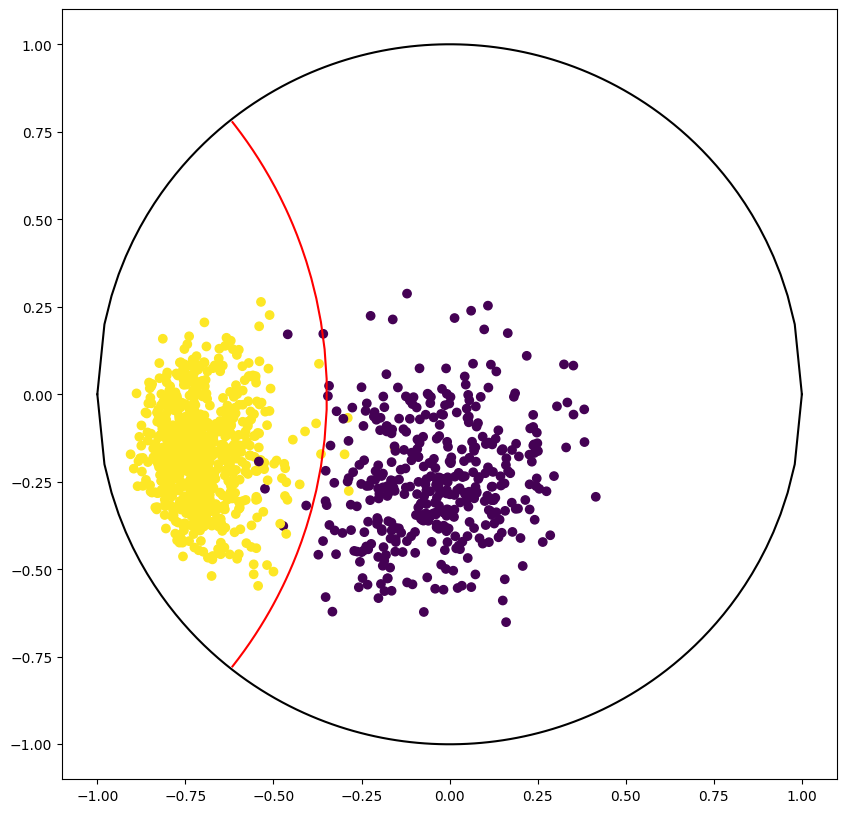

In [192]:
ax = plot_boundary(hdt, X, y, geometry="poincare")
plt.show()
